In [93]:
import nibabel as nib
import pandas as pd
import os
import numpy as np
import random
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from scipy import ndimage

import tensorflow as tf
from tensorflow import keras
from keras.optimizers import Adam
from keras.layers import Conv3D, MaxPooling3D, GlobalAveragePooling3D, BatchNormalization, Dense, Dropout
from keras.metrics import Accuracy, MeanSquaredError, AUC, Recall, TruePositives, FalseNegatives, BinaryAccuracy


def load_nifti_image(file_path):
    """Read and load volume"""
    # Read file
    img = nib.load(file_path)
    # Get raw data
    img = img.get_fdata()
    return img


def normalize(img):
    """Normalize the img"""
    min = -1000
    max = 400
    img[img < min] = min
    img[img > max] = max
    img = (img - min) / (max - min)
    img = img.astype("float32")
    return img


def reshape(img):
    """Resize across z-axis"""
    # Set the desired depth
    img_desired_depth = 64
    img_desired_width = 128
    img_desired_height = 128
    # Get current depth
    current_depth = img.shape[-1]
    current_width = img.shape[0]
    current_height = img.shape[1]
    # Compute depth factor
    depth = current_depth / img_desired_depth
    width = current_width / img_desired_width
    height = current_height / img_desired_height
    depth_factor = 1 / depth
    width_factor = 1 / width
    height_factor = 1 / height
    # Rotate
    img = ndimage.rotate(img, 90, reshape=False)
    # Resize across z-axis
    img = ndimage.zoom(img, (width_factor, height_factor, depth_factor), order=1)
    return img


def process_image(path):
    """Read and resize volume"""
    try:
        img = load_nifti_image(path)
        img = normalize(img)
        img = reshape(img)
        return img
    
    except Exception as e:
        print(path)
        print(repr(e))



In [94]:
features = pd.read_csv(os.path.join(os.getcwd(), "Label_file.csv"))
features.head()

,Filename,Recognizable-Facial-Feature,Brain-Feature-Loss
0,IXI369-Guys-0924-T1_bet_03.nii,Yes,No
1,IXI448-HH-2393-T1_bet_07.nii,Yes,No
2,IXI252-HH-1693-T1_bet_08.nii,Yes,No
3,IXI188-Guys-0798-T1_bet_17.nii,Yes,No
4,IXI182-Guys-0792-T1_bet_17.nii,Yes,No


In [95]:
file_names = os.listdir(os.path.join(os.getcwd(), "files"))
file_names[:2]

['IXI482-HH-2178-T1_bet_86.nii.gz', 'IXI627-Guys-1103-T1_bet_83.nii.gz']

In [96]:
labels = np.array([])
for n in file_names:
    labels = np.append(labels, features[features["Filename"] == n.strip(".gz")]["Recognizable-Facial-Feature"])
labels[:2]

array(['No', 'No'], dtype=object)

In [97]:
file_paths = [os.path.join(os.getcwd(), "files", f) for f in file_names]
file_paths[:2]

['/Users/kitap/dev/clemson/course_work/sem3/cpsc8650/BET_BSE_DATA/files/IXI482-HH-2178-T1_bet_86.nii.gz',
 '/Users/kitap/dev/clemson/course_work/sem3/cpsc8650/BET_BSE_DATA/files/IXI627-Guys-1103-T1_bet_83.nii.gz']

In [98]:
norm_images = np.array([process_image(p) for p in file_paths])

In [99]:
labels = np.array([1 if label == 'Yes' else 0 for label in labels])
labels[:5]

array([0, 0, 0, 1, 0])

In [100]:
X_train, X_test, Y_train, Y_test = train_test_split(norm_images, labels, test_size=0.4, random_state=42)

In [101]:
# For nested cross-validation
# Run an outer loop of k-fold cross-validation to split the data into training and testing sets, 
# and then an inner loop of k-fold cross-validation to tune hyperparameters on the training data 
# and evaluate model performance on the testing data.
x_train, x_val, y_train, y_val = train_test_split(X_train, Y_train, test_size=0.4, random_state=42)

In [102]:
@tf.function
def rotate(volume):
    """Rotate the volume by a few degrees"""

    def scipy_rotate(volume):
        # define some rotation angles
        angles = [-20, -10, -5, 5, 10, 20]
        # pick angles at random
        angle = random.choice(angles)
        # rotate volume
        volume = ndimage.rotate(volume, angle, reshape=False)
        volume[volume < 0] = 0
        volume[volume > 1] = 1
        return volume

    aug_volume = tf.numpy_function(scipy_rotate, [volume], tf.float32)
    return aug_volume


def train_preprocessing(volume, label):
    """Process training data by rotating and adding a channel."""
    # Rotate volume
    volume = rotate(volume)
    volume = tf.expand_dims(volume, axis=3)
    return volume, label


def validation_preprocessing(volume, label):
    """Process validation data by only adding a channel."""
    volume = tf.expand_dims(volume, axis=3)
    return volume, label


In [103]:
#enter the train test split cell here and rename the variable in train loader and validation loader
train_loader = tf.data.Dataset.from_tensor_slices((x_train, y_train))
validation_loader = tf.data.Dataset.from_tensor_slices((tf.convert_to_tensor(x_val), tf.convert_to_tensor(y_val)))

batch_size = 2
# Augment the on the fly during training.
train_dataset = (
    train_loader.shuffle(len(x_train))
    .map(train_preprocessing)
    .batch(batch_size)
    .prefetch(2)
)
# Only rescale.
validation_dataset = (
    validation_loader.shuffle(len(x_val))
    .map(validation_preprocessing)
    .batch(batch_size)
    .prefetch(2)
)

In [104]:
def make_model(width=128, height=128, depth=64):
    """Build a 3D convolutional neural network model."""

    inputs = keras.Input((width, height, depth, 1))

    x = Conv3D(filters=64, kernel_size=3, activation="relu")(inputs)
    x = MaxPooling3D(pool_size=2)(x)
    x = BatchNormalization()(x)

    x = Conv3D(filters=64, kernel_size=3, activation="relu")(x)
    x = MaxPooling3D(pool_size=2)(x)
    x = BatchNormalization()(x)

    x = Conv3D(filters=128, kernel_size=3, activation="relu")(x)
    x = MaxPooling3D(pool_size=2)(x)
    x = BatchNormalization()(x)

    x = Conv3D(filters=256, kernel_size=3, activation="relu")(x)
    x = MaxPooling3D(pool_size=2)(x)
    x = BatchNormalization()(x)

    x = GlobalAveragePooling3D()(x)
    x = Dense(units=512, activation="relu")(x)
    x = Dropout(0.3)(x)

    outputs = Dense(units=1, activation="sigmoid")(x)

    # Define the model.
    model = keras.Model(inputs, outputs, name="3dcnn")
    return model


# Build model.
model = make_model(width=128, height=128, depth=64)
model.summary()

Model: "3dcnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 128, 64, 1)  0         
                             ]                                   
                                                                 
 conv3d_4 (Conv3D)           (None, 126, 126, 62, 64)  1792      
                                                                 
 max_pooling3d_4 (MaxPooling  (None, 63, 63, 31, 64)   0         
 3D)                                                             
                                                                 
 batch_normalization_4 (Batc  (None, 63, 63, 31, 64)   256       
 hNormalization)                                                 
                                                                 
 conv3d_5 (Conv3D)           (None, 61, 61, 29, 64)    110656    
                                                             

In [105]:
# Compile model.
initial_learning_rate = 0.0001
learning_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
)
model.compile(
    loss="binary_crossentropy",
    optimizer=Adam(learning_rate=learning_schedule),
    metrics=[Accuracy(), MeanSquaredError(), AUC(), Recall(), TruePositives(), FalseNegatives()],
)

# Define callbacks.
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    "3d_image_classification.h5", save_best_only=True
)
early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor="val_acc", patience=15)

# Train the model, doing validation at the end of each epoch
epochs = 5
model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    shuffle=True,
    verbose=2,
    callbacks=[checkpoint_cb, early_stopping_cb],
)

Epoch 1/5
144/144 - 605s - loss: 0.3780 - accuracy: 0.0000e+00 - mean_squared_error: 0.1258 - auc_1: 0.9009 - recall_1: 0.7987 - true_positives_1: 123.0000 - false_negatives_1: 31.0000 - val_loss: 1.7024 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 0.4758 - val_auc_1: 0.9861 - val_recall_1: 0.0000e+00 - val_true_positives_1: 0.0000e+00 - val_false_negatives_1: 99.0000 - 605s/epoch - 4s/step
Epoch 2/5
144/144 - 604s - loss: 0.3425 - accuracy: 0.0000e+00 - mean_squared_error: 0.1133 - auc_1: 0.9227 - recall_1: 0.8312 - true_positives_1: 128.0000 - false_negatives_1: 26.0000 - val_loss: 2.0406 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 0.4927 - val_auc_1: 0.9899 - val_recall_1: 0.0000e+00 - val_true_positives_1: 0.0000e+00 - val_false_negatives_1: 99.0000 - 604s/epoch - 4s/step
Epoch 3/5
144/144 - 601s - loss: 0.2505 - accuracy: 0.0000e+00 - mean_squared_error: 0.0786 - auc_1: 0.9587 - recall_1: 0.8831 - true_positives_1: 136.0000 - false_negatives_1: 18.0000 - val_loss:

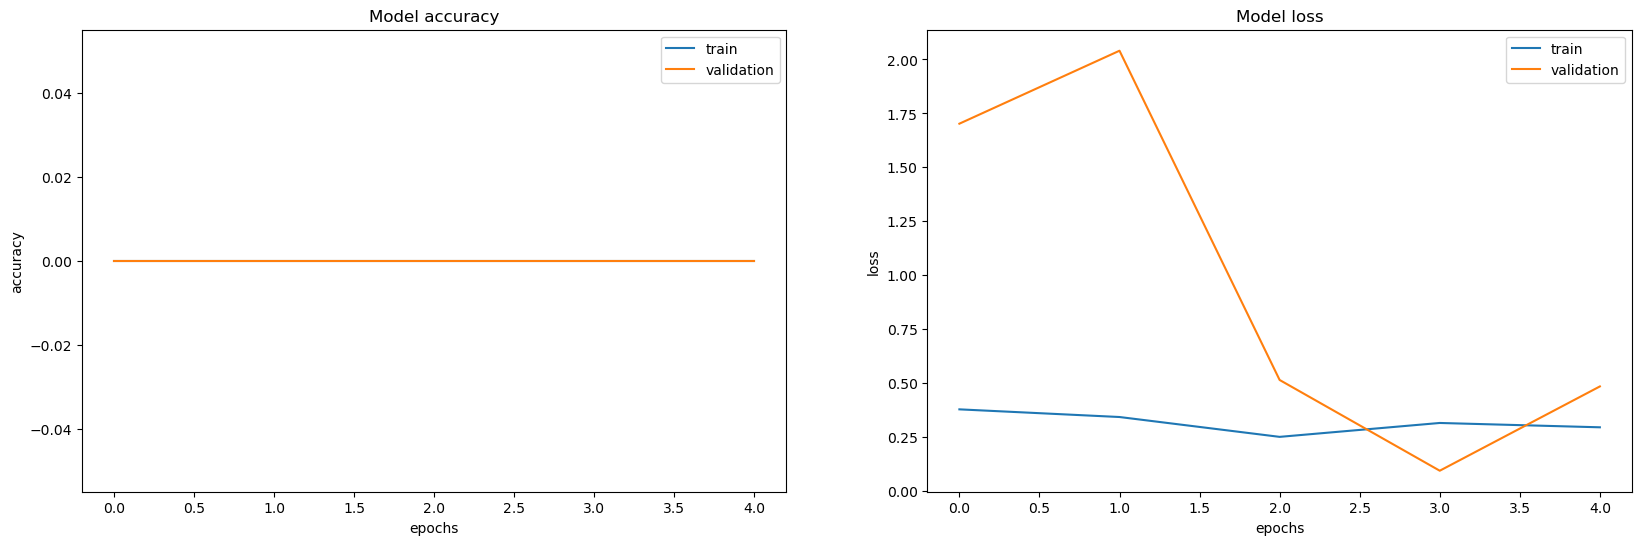

In [106]:
fig, ax = plt.subplots(1, 2, figsize=(20, 6))
ax = ax.ravel()

for i, metric in enumerate(["accuracy", "loss"]):
    ax[i].plot(model.history.history[metric])
    ax[i].plot(model.history.history["val_" + metric])
    ax[i].set_title("Model {}".format(metric))
    ax[i].set_xlabel("epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend(["train", "validation"])

In [107]:
model.load_weights("3d_image_classification.h5")
new_list=[]
for i in range(len(X_test)):
    prediction = model.predict(np.expand_dims(X_test[i], axis=0))[0]
    scores = [1 - prediction[0], prediction[0]]
    new_list.append([prediction[0]])
new_list

1/1 [==============================] - 0s 188ms/step


[[0.9999003],
 [0.011785638],
 [0.9999762],
 [0.9999069],
 [0.027730998],
 [0.9996876],
 [0.99955374],
 [0.002634281],
 [0.9999793],
 [0.99973714],
 [0.003359628],
 [0.99990904],
 [0.99968773],
 [0.005376101],
 [0.9966875],
 [0.99994487],
 [0.9996181],
 [0.0033364645],
 [0.99991715],
 [0.0018454986],
 [0.9998076],
 [0.19536482],
 [0.99990577],
 [0.9998582],
 [0.0023545362],
 [0.0002740447],
 [0.9978773],
 [0.016454957],
 [0.0025147256],
 [0.99848056],
 [0.99855983],
 [0.026820974],
 [0.0033890714],
 [0.99227524],
 [1.1407789e-05],
 [0.07057164],
 [0.0009898621],
 [0.9997427],
 [0.9994242],
 [0.99619454],
 [0.00093100197],
 [0.9989803],
 [0.9989386],
 [0.0007360388],
 [0.9975049],
 [0.9995281],
 [0.009957723],
 [0.9962076],
 [0.023832228],
 [0.9998295],
 [0.0012160693],
 [0.9995495],
 [0.0012422991],
 [0.99975],
 [0.9995838],
 [0.0004671252],
 [0.99996525],
 [0.9998937],
 [0.99934953],
 [0.9999358],
 [0.9998265],
 [0.99012583],
 [0.99854445],
 [0.99970984],
 [0.027329303],
 [0.99992317]

In [108]:
test_list=[]
for i in Y_test:
    test_list.append([i])
test_list

[[1],
 [0],
 [1],
 [1],
 [0],
 [1],
 [1],
 [0],
 [1],
 [1],
 [0],
 [1],
 [1],
 [0],
 [1],
 [1],
 [1],
 [0],
 [1],
 [0],
 [1],
 [0],
 [1],
 [1],
 [0],
 [0],
 [1],
 [0],
 [0],
 [1],
 [1],
 [0],
 [0],
 [1],
 [0],
 [0],
 [0],
 [1],
 [1],
 [1],
 [0],
 [1],
 [1],
 [0],
 [1],
 [1],
 [0],
 [1],
 [0],
 [1],
 [0],
 [1],
 [0],
 [1],
 [1],
 [0],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [0],
 [1],
 [0],
 [0],
 [0],
 [1],
 [0],
 [1],
 [1],
 [1],
 [0],
 [1],
 [1],
 [1],
 [1],
 [0],
 [0],
 [0],
 [0],
 [1],
 [0],
 [0],
 [0],
 [1],
 [0],
 [1],
 [1],
 [1],
 [1],
 [1],
 [0],
 [1],
 [0],
 [1],
 [0],
 [1],
 [0],
 [0],
 [0],
 [0],
 [0],
 [1],
 [1],
 [1],
 [0],
 [0],
 [1],
 [0],
 [0],
 [1],
 [1],
 [1],
 [1],
 [0],
 [0],
 [1],
 [1],
 [1],
 [0],
 [1],
 [0],
 [1],
 [0],
 [0],
 [1],
 [0],
 [1],
 [1],
 [1],
 [1],
 [0],
 [0],
 [0],
 [0],
 [1],
 [1],
 [1],
 [1],
 [0],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [0],
 [1],
 [1],
 [0],
 [1],
 [0],
 [0],
 [0],
 [1],
 [1],
 [1],
 [0],
 [1],
 [1],
 [0],
 [0],
 [1]

In [109]:
prediction[:5]

array([0.99932885], dtype=float32)

In [110]:
m = BinaryAccuracy()
m.update_state(test_list, new_list)

<tf.Variable 'UnreadVariable' shape=() dtype=float32, numpy=321.0>

In [111]:
model_accuracy=m.result().numpy()*100
model_accuracy

99.68847632408142